This notebook describes a simple machine learning process to predict today's temperature. It is based on 2016 data of seattle. Finding more recent data was quite challenging. After building the model. I will find a larger time-series data to train the model on. 

The question considered here is - if i know yesterday's max temperature and the day before's, can I predict today's temperature?

We will compare our result to NOAA's predictions as well as a friend of mine's who claims to know all about temperature prediction.

In [1]:
# conda install pydot

In [2]:
# import libraries
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pydot
%matplotlib inline
plt.style.use('seaborn-bright')

import datetime as dt
#machine learning

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [4]:
data = pd.read_csv('temps.csv')
data.head()

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


Data dictionary
1. year: 2016 for all data points
2. month: number for month of the year
3. day: number for day of the year
4. week: day of the week as a character string
5. temp_2: max temperature 2 days prior
6. temp_1: max temperature 1 day prior
7. average: historical average max temperature
8. actual: max temperature measurement
9. friend: your friend’s prediction, a random number between 20 below the average and 20 above the average

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb05e7c8d68>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb05e7c8d68>)

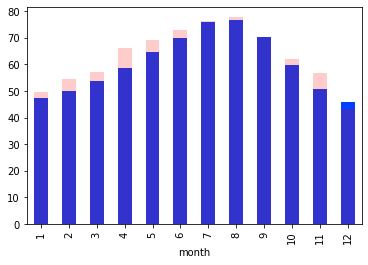

In [73]:
data.groupby('month').average.mean().plot.bar(),data.groupby('month').actual.mean().plot.bar(alpha =0.2, color = 'red')

In [11]:
data.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


In [13]:
print(data.isnull().sum(), '\n', 'No missing information!')

year              0
month             0
day               0
week              0
temp_2            0
temp_1            0
average           0
actual            0
forecast_noaa     0
forecast_acc      0
forecast_under    0
friend            0
dtype: int64 
 No missing information!


In [52]:
print('R2')
data.corr()['actual']**2

R2


year                       NaN
month             2.051279e-05
day               4.698004e-04
temp_2            6.493708e-01
temp_1            7.706729e-01
average           7.197238e-01
actual            1.000000e+00
forecast_noaa     7.033158e-01
forecast_acc      7.091915e-01
forecast_under    7.038307e-01
friend            3.239255e-01
Fri               7.983385e-05
Mon               2.806035e-06
Sat               6.325158e-04
Sun               3.485032e-04
Thurs             2.151415e-05
Tues              1.404516e-03
Wed               1.843530e-07
Name: actual, dtype: float64

In [5]:
#To visualize changes in temperature with time create date column

data['date'] = data.year.astype(str)+ '-' + data.month.astype(str)+'-'+ data.day.astype(str)
data.date = pd.to_datetime(data.date)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   year            348 non-null    int64         
 1   month           348 non-null    int64         
 2   day             348 non-null    int64         
 3   week            348 non-null    object        
 4   temp_2          348 non-null    int64         
 5   temp_1          348 non-null    int64         
 6   average         348 non-null    float64       
 7   actual          348 non-null    int64         
 8   forecast_noaa   348 non-null    int64         
 9   forecast_acc    348 non-null    int64         
 10  forecast_under  348 non-null    int64         
 11  friend          348 non-null    int64         
 12  date            348 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(10), object(1)
memory usage: 35.5+ KB


In [6]:
data.date.dt.month

0       1
1       1
2       1
3       1
4       1
       ..
343    12
344    12
345    12
346    12
347    12
Name: date, Length: 348, dtype: int64

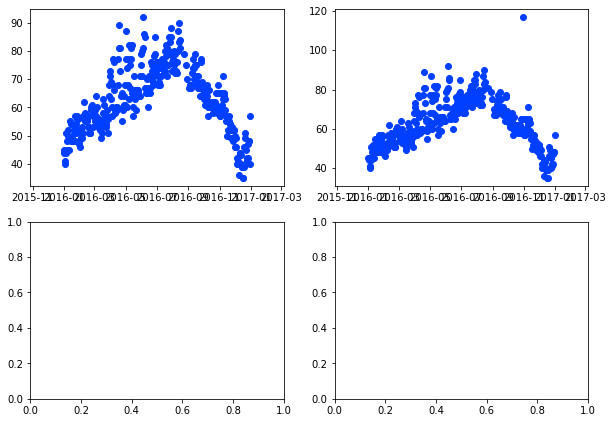

In [15]:
fig = plt.figure(figsize=(10,15))
ax1 = fig.add_subplot(4,2,1)
ax2 = fig.add_subplot(4,2,2)
ax3 = fig.add_subplot(4,2,3)
ax4 = fig.add_subplot(4,2,4)

ax1.scatter(data['date'], data['actual'])
ax1.set_xlabel('')
ax1.set_ylabel('')
# ax1.set_xlim(0, 5)
# ax1.set_ylim(0, 5)

ax2.scatter(data['date'], data['temp_1'])
ax2.set_xlabel('')
ax2.set_ylabel('')
# ax2.set_xlim(0, 5)
# ax2.set_ylim(0, 5)

# ax3.scatter(norm_reviews['Fandango_Ratingvalue'], norm_reviews['IMDB_norm'])
# ax3.set_xlabel('Fandango')
# ax3.set_ylabel('IMDB')
# ax3.set_xlim(0, 5)
# ax3.set_ylim(0, 5)

plt.show()


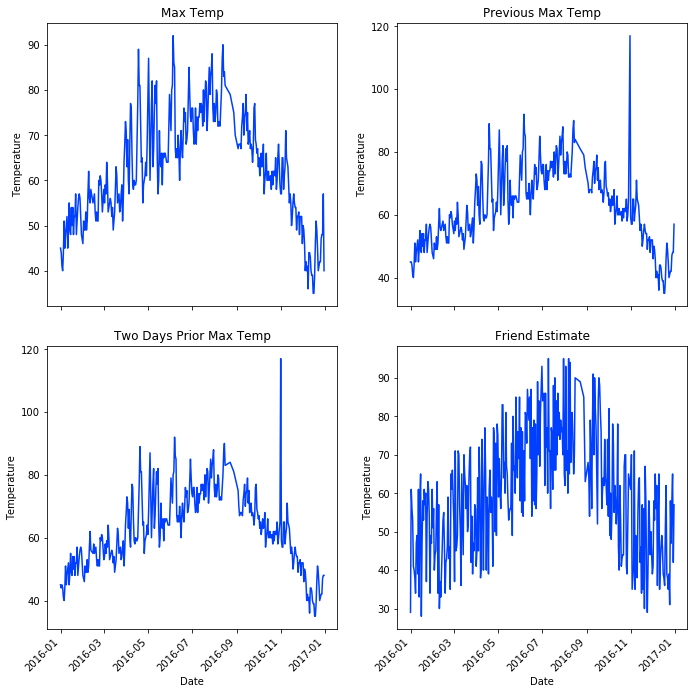

In [11]:
 ### plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# Actual max temperature measurement
ax1.plot(data.date, data.actual)
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# Temperature from 1 day ago
ax2.plot(data.date, data['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# # Temperature from 2 days ago
ax3.plot(data.date, data['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# # Friend Estimate
ax4.plot(data.date, data['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

In [24]:
###. Convert features dummy


# features = ['month', 'day', 'week' , 'temp_2','temp_1','average']

# pd.get_dummies(data['week'])

,Fri,Mon,Sat,Sun,Thurs,Tues,Wed
0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
343,0,0,0,0,0,0,0
344,0,0,0,0,0,0,0
345,0,0,0,0,0,0,0
346,0,0,0,0,0,0,0


In [7]:
data = pd.concat([data,pd.get_dummies(data.week)],axis = 1)
data.drop('week',axis = 1, inplace = True)
data.head()


,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,date,Fri,Mon,Sat,Sun,Thurs,Tues,Wed
0,2016,1,1,45,45,45.6,45,43,50,44,29,2016-01-01,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,41,50,44,61,2016-01-02,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,43,46,47,56,2016-01-03,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,44,48,46,53,2016-01-04,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,46,46,46,41,2016-01-05,0,0,0,0,0,1,0


In [8]:
target = 'actual'
features = data.columns
features = features.to_list()
to_remove =  ['year','forecast_noaa', 'forecast_acc', 'forecast_under','date', 'actual']

In [9]:
new_cols = [i for i in features if i not in to_remove]
new_cols

['month',
 'day',
 'temp_2',
 'temp_1',
 'average',
 'friend',
 'Fri',
 'Mon',
 'Sat',
 'Sun',
 'Thurs',
 'Tues',
 'Wed']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data[new_cols], data[target],test_size=0.30, random_state=23 )

In [11]:
X_train.shape, X_test.shape

((243, 13), (105, 13))

Average baseline error:  4.61 degrees.
Accuracy: 95.39


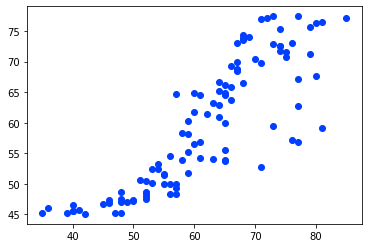

In [12]:
# The baseline predictions are the historical averages
baseline_preds = X_test['average']

# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - y_test)
print('Average baseline error: ', round(np.mean(baseline_errors), 2), 'degrees.')
print('Accuracy:' , 100 - round(np.mean(baseline_errors), 2))

plt.scatter(y_test, X_test['average'])

Historical avearages seem to be quite close to actual values.. model must beat this.

## Train model

Training
Average rf error:  2.59 degrees.
Accuracy: 97.41
mse 11.038694969003572


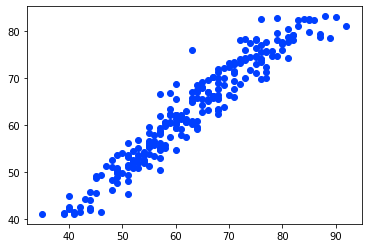

In [13]:
rf = RandomForestRegressor(n_estimators=200, random_state=23, min_samples_leaf=5)
rf.fit(X_train, y_train)
error = abs(y_train - rf.predict(X_train))
print('Training')
print('Average rf error: ', round(np.mean(error), 2), 'degrees.')
print('Accuracy:' , 100 - round(np.mean(error), 2))
print('mse' , mean_squared_error(y_train, rf.predict(X_train)))
plt.scatter(y_train, rf.predict(X_train))

## Test the model

Average rf error:  3.82 degrees.
Accuracy: 96.18
mse 23.860973978886545


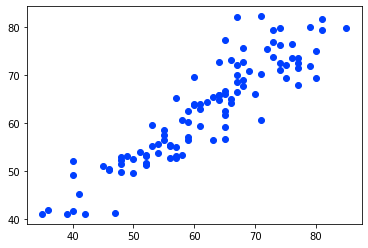

In [14]:
error = abs(y_test - rf.predict(X_test))
print('Average rf error: ', round(np.mean(error), 2), 'degrees.')
print('Accuracy:' , 100 - round(np.mean(error), 2))
print('mse' , mean_squared_error(y_test, rf.predict(X_test)))
plt.scatter(y_test, rf.predict(X_test))

In [38]:
Mean absolute error
100-np.mean(100*(error/y_test))

99.79045030110204

## Model improvement

Training
Average rf error:  1.36 degrees.
Accuracy: 98.64
mse 3.181643678965669
Test
Average rf error:  3.92 degrees.
Accuracy: 96.08
mse 25.670528400396076


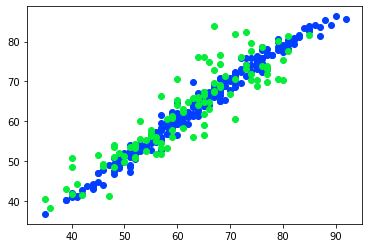

In [26]:
rf = RandomForestRegressor(n_estimators=46, random_state=23)
rf.fit(X_train, y_train)
error = abs(y_train - rf.predict(X_train))
print('Training')
print('Average rf error: ', round(np.mean(error), 2), 'degrees.')
print('Accuracy:' , 100 - round(np.mean(error), 2))
print('mse' , mean_squared_error(y_train, rf.predict(X_train)))
plt.scatter(y_train, rf.predict(X_train))

print('Test')
error = abs(y_test - rf.predict(X_test))
print('Average rf error: ', round(np.mean(error), 2), 'degrees.')
print('Accuracy:' , 100 - round(np.mean(error), 2))
print('mse' , mean_squared_error(y_test, rf.predict(X_test)))
plt.scatter(y_test, rf.predict(X_test))

1. What exactly is going on under the hood? Visualize
2. Model improvement. What can be done to improve the model

In [27]:
# Import tools for visualizing decision tree
from sklearn.tree import export_graphviz

# Pull out a tree from the forest(tree number 5)
tree = rf.estimators_[8]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = new_cols, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
# graph.write_png('tree8.png')

In [28]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 12


#### Current tree has a depth of 12. Can lets see what happens when we reduce this

Average rf error:  3.77 degrees.
Accuracy: 96.23
mse 23.923744611500165


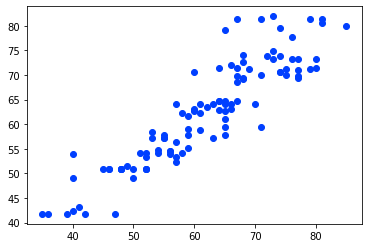

In [29]:
small_rf = RandomForestRegressor(n_estimators=10,  max_depth=3, random_state=23)
small_rf.fit(X_train, y_train)
error = abs(y_test - small_rf.predict(X_test))
print('Average rf error: ', round(np.mean(error), 2), 'degrees.')
print('Accuracy:' , 100 - round(np.mean(error), 2))
print('mse' , mean_squared_error(y_test, small_rf.predict(X_test)))
plt.scatter(y_test, small_rf.predict(X_test))

In [36]:
# Pull out a tree from the forest(tree number 5)
tree = small_rf.estimators_[8]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = new_cols, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree8_2.png')

## Feature importance

In [50]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
importances

# # List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(new_cols, importances)]

# # Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_importances
# # Print out the feature and importances 
[print('Variable: {:15} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: temp_1          Importance: 0.48
Variable: average         Importance: 0.41
Variable: friend          Importance: 0.03
Variable: month           Importance: 0.02
Variable: day             Importance: 0.02
Variable: temp_2          Importance: 0.02
Variable: Fri             Importance: 0.0
Variable: Mon             Importance: 0.0
Variable: Sat             Importance: 0.0
Variable: Sun             Importance: 0.0
Variable: Thurs           Importance: 0.0
Variable: Tues            Importance: 0.0
Variable: Wed             Importance: 0.0
